In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

Notice: Each tree model will be set with seed = 114514 for reproductive results

## Part I: Data Processing

Before we divide data into training and testing set, we should firstly have a look at how they are distributed.

In [2]:
data = pd.read_csv('diabetes.csv')
data = data.astype(int)
print((data==0).sum())

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction    717
Age                           0
Outcome                     500
dtype: int64


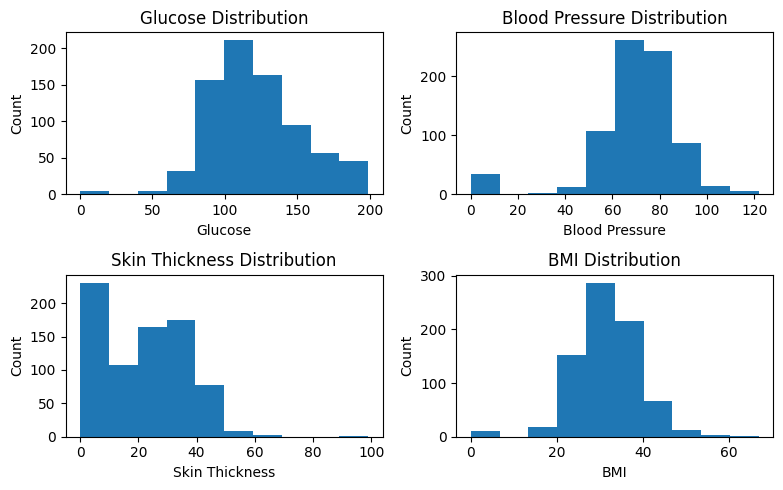

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

axes[0, 0].hist(data['Glucose'])
axes[0, 0].set_title('Glucose Distribution')
axes[0, 0].set_xlabel('Glucose')
axes[0, 0].set_ylabel('Count')


axes[0, 1].hist(data['BloodPressure'])
axes[0, 1].set_title('Blood Pressure Distribution')
axes[0, 1].set_xlabel('Blood Pressure')
axes[0, 1].set_ylabel('Count')


axes[1, 0].hist(data['SkinThickness'])
axes[1, 0].set_title('Skin Thickness Distribution')
axes[1, 0].set_xlabel('Skin Thickness')
axes[1, 0].set_ylabel('Count')

axes[1, 1].hist(data['BMI'])
axes[1, 1].set_title('BMI Distribution')
axes[1, 1].set_xlabel('BMI')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

From the statistic table we should claim that there exist some issue in some feature columns

If we directly drop these 0-value rows we will lose too many samples, instead we use the current average value to replace these values.

In one word, we will deal with SkinThickness

In [4]:
data['SkinThickness'] = data['SkinThickness'].replace(0, data['SkinThickness'].mean())
data = data[(data[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']] != 0).all(axis=1)]

<AxesSubplot:>

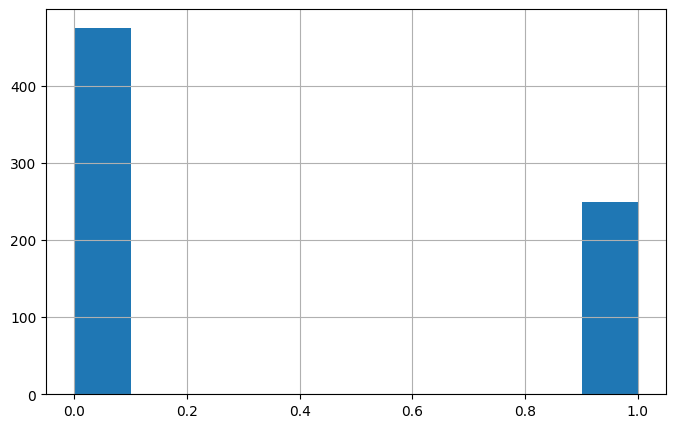

In [5]:
data['Outcome'].hist(figsize=(8, 5))

## Part II: Uni-Variate Decision Tree

In [6]:
features = data.iloc[:, :-1]
target = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=114514)

print('training set shape: ', X_train.shape)
print('training set shape: ', y_train.shape)
print('testing set shape: ', X_test.shape)
print('training set shape: ', y_train.shape)

training set shape:  (485, 8)
training set shape:  (485,)
testing set shape:  (239, 8)
training set shape:  (485,)


Use a $decision \ tree$ to handle this problem

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       156
           1       0.67      0.57      0.61        83

    accuracy                           0.75       239
   macro avg       0.73      0.71      0.72       239
weighted avg       0.75      0.75      0.75       239



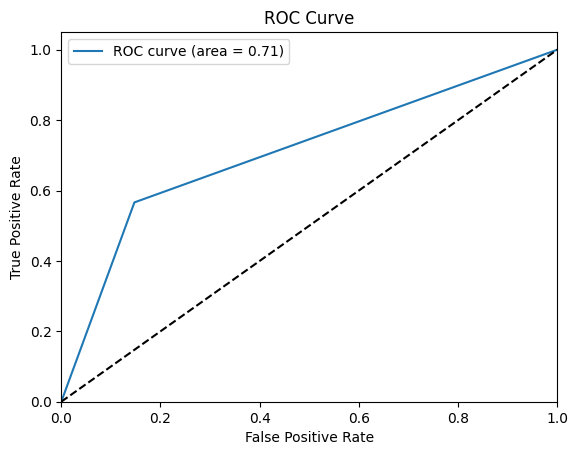

In [7]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=10, min_samples_leaf=8, random_state=114514)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

From above we may conclude that univariate tree methods such as decision tree classifier may not perform well on this dataset. Its accuracy is only 71%, which could be quite bad.

Possible reasons:

1. The univarative tree ignores the relationship between features, which their combination may have significant impacts on predictions.

2. Dataset imbalance, there are 500 not-type and about 200 yes-type, which could mislead the tree.

3. The features' distributions are complicated, which can't be handle by single tree methods.

Then check how the tree split the space

[Text(0.654796511627907, 0.9545454545454546, 'Glucose <= 154.5\ngini = 0.45\nsamples = 485\nvalue = [319, 166]\nclass = No'),
 Text(0.3561046511627907, 0.8636363636363636, 'Age <= 30.5\ngini = 0.373\nsamples = 404\nvalue = [304, 100]\nclass = No'),
 Text(0.1744186046511628, 0.7727272727272727, 'Glucose <= 105.5\ngini = 0.232\nsamples = 232\nvalue = [201, 31]\nclass = No'),
 Text(0.046511627906976744, 0.6818181818181818, 'Insulin <= 68.0\ngini = 0.082\nsamples = 93\nvalue = [89, 4]\nclass = No'),
 Text(0.023255813953488372, 0.5909090909090909, 'gini = 0.0\nsamples = 64\nvalue = [64, 0]\nclass = No'),
 Text(0.06976744186046512, 0.5909090909090909, 'Pregnancies <= 1.5\ngini = 0.238\nsamples = 29\nvalue = [25, 4]\nclass = No'),
 Text(0.046511627906976744, 0.5, 'gini = 0.0\nsamples = 13\nvalue = [13, 0]\nclass = No'),
 Text(0.09302325581395349, 0.5, 'SkinThickness <= 22.5\ngini = 0.375\nsamples = 16\nvalue = [12, 4]\nclass = No'),
 Text(0.06976744186046512, 0.4090909090909091, 'gini = 0.219

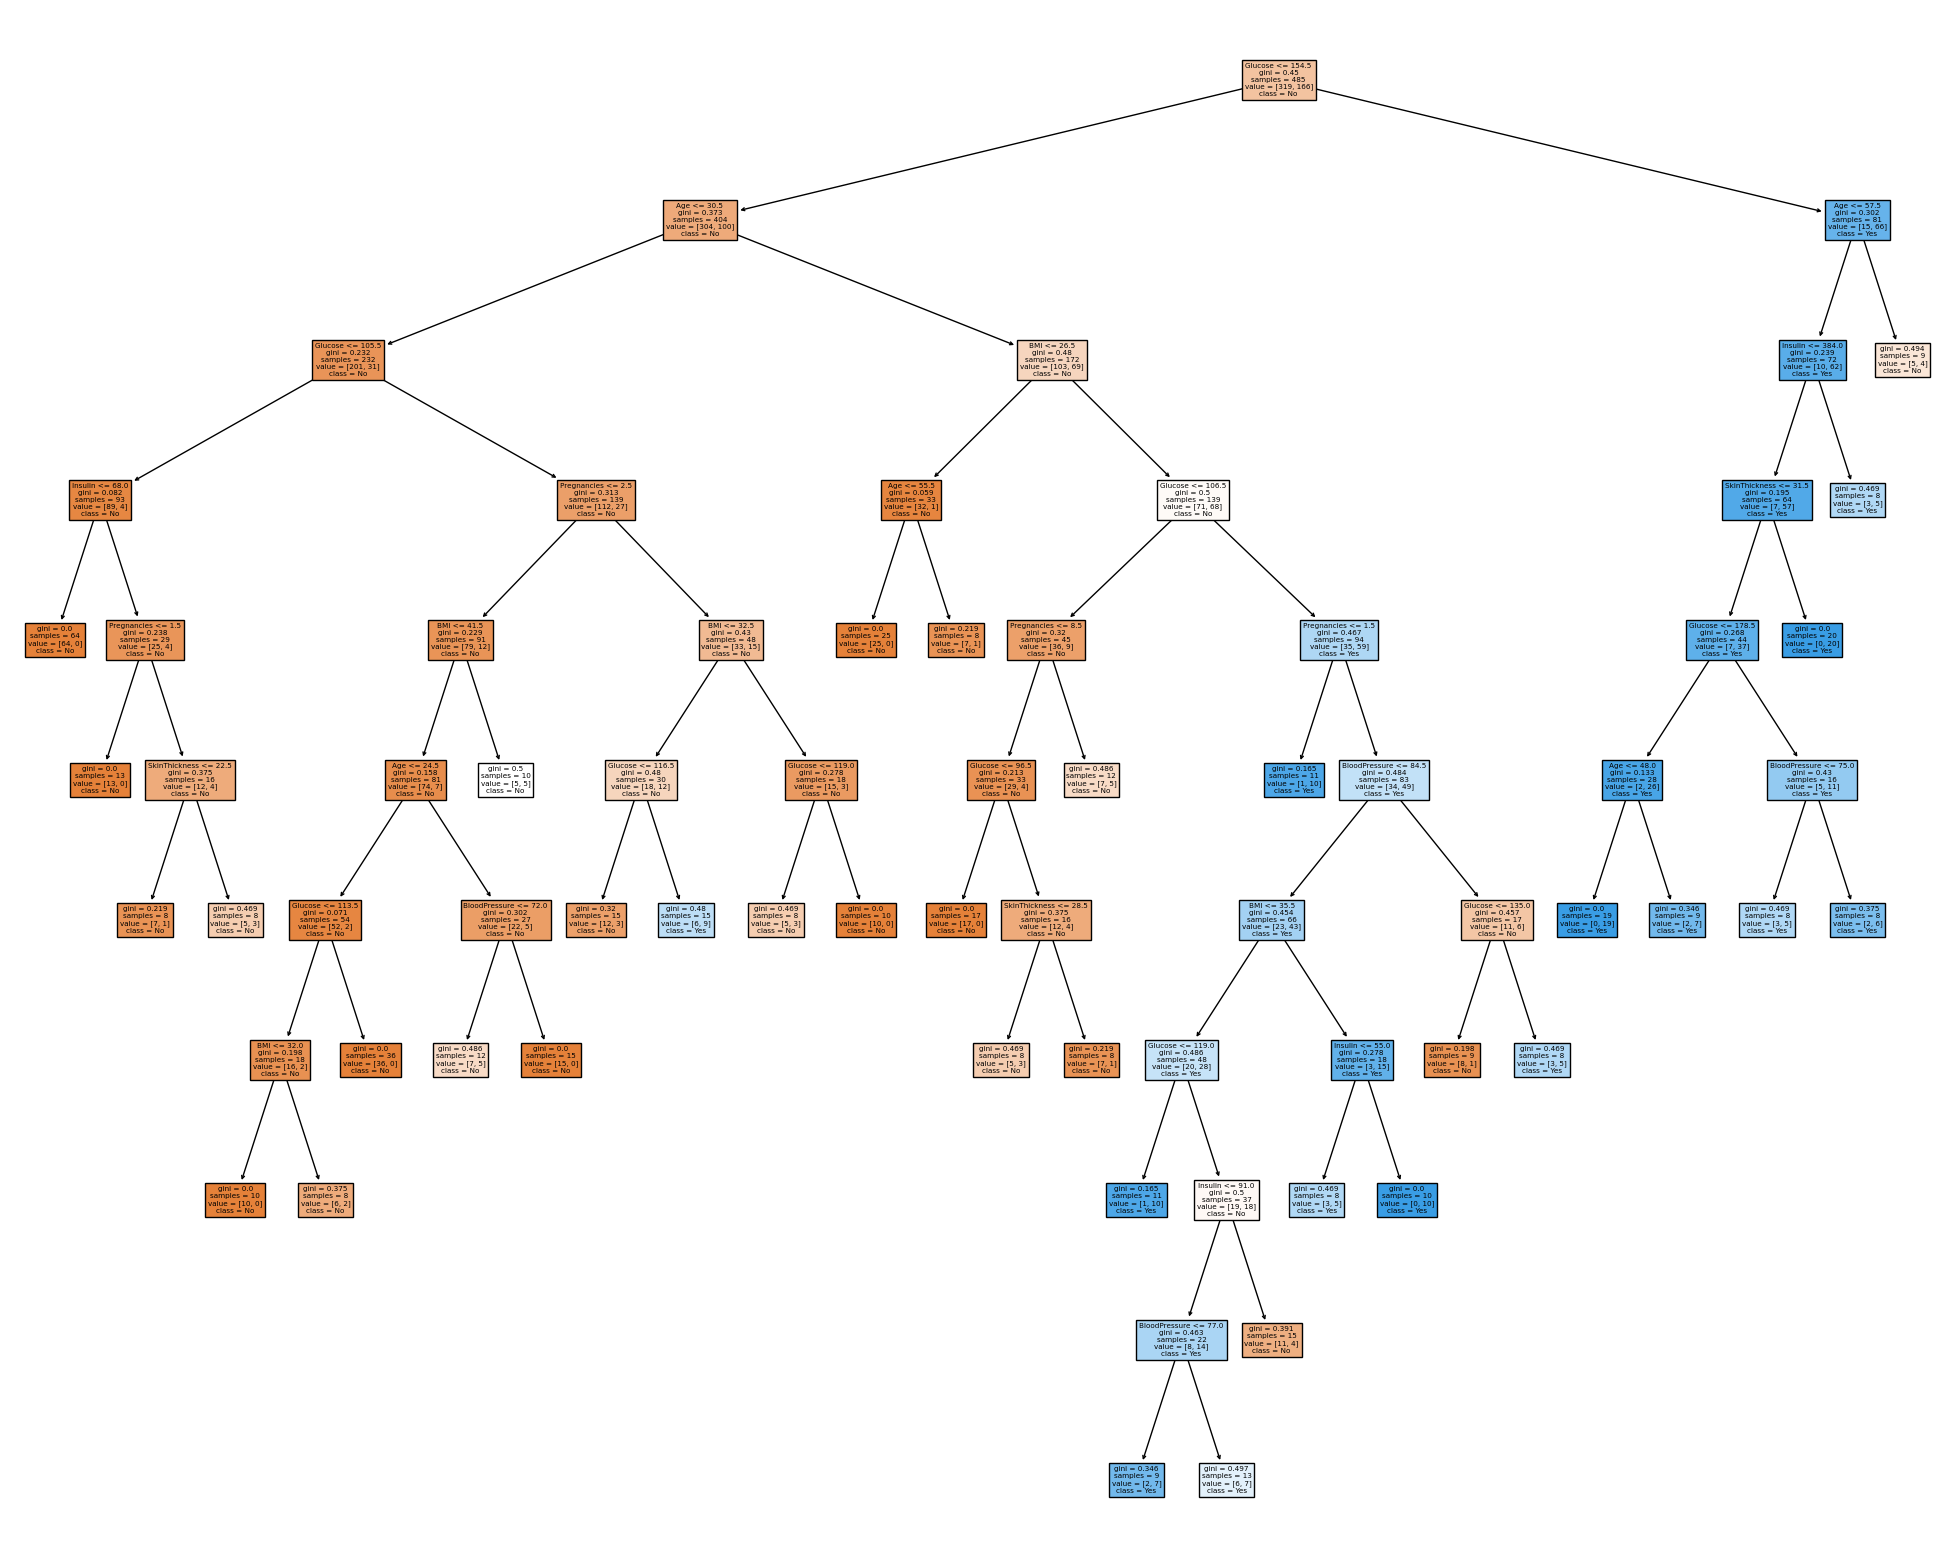

In [8]:
plt.figure(figsize=(25, 20))
plot_tree(classifier, feature_names=features.columns, class_names=['No', 'Yes'], filled=True)

## Part III: Ensemble Model

In this part we use $Random \ Forest$ as the ensemble model

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       156
           1       0.70      0.57      0.63        83

    accuracy                           0.77       239
   macro avg       0.75      0.72      0.73       239
weighted avg       0.76      0.77      0.76       239



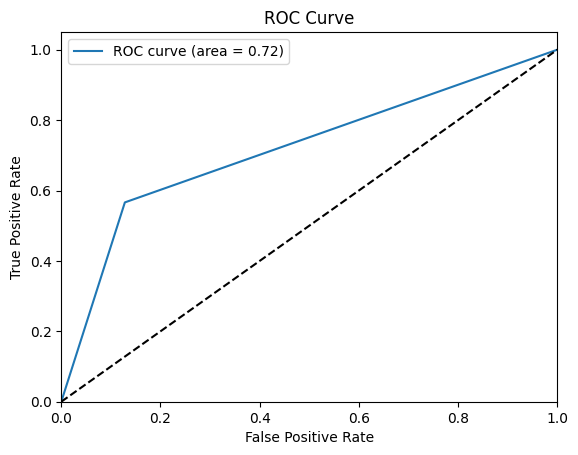

In [9]:
rf_classifier = RandomForestClassifier(max_features=50, n_estimators=100,random_state=114514)
rf_classifier.fit(X_train, y_train)
y_pred_ens = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred_ens))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_ens)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In this section, the random forest and xgboost model performs better than the univariate one, whose accuracy level up to 77% compare to 71%.

Possible reasons:

1. Combines multi decision trees' results, which can be more robust.

2. Random forest will essintially generate trees with the largest variations, which can capture the correlation between some features within each tree.

3. Ensemble methods behave better than univariate method when dealing with the fewer label.

## Part IV: Conclusion

1. When dealing with imbalance targets, ensemble methods are better than univariate methods. 

2. The accuracy is not monotonically increasing with the number of estimators, nodes, or depths.

3. There are tradeoffs between performance and computational cost.